# Simple ring parameter constraints

This notebook provides test cases for the precision of a simple lens model (with simplified assumptions). This is for show-casing and to assess the uncertainty limit in how well the parameters of this model can be constrained.


In [1]:
# import of standard python libraries
import numpy as np
import os
import time
import corner
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

## simulation choices

In [2]:
# data specifics
background_rms = .005  #  background noise per pixel
exp_time = 500.  #  exposure time (arbitrary units, flux per pixel is in units #photons/exp_time unit)
numPix = 60  #  cutout pixel size
deltaPix = 0.05  #  pixel size in arcsec (area per pixel = deltaPix**2)
fwhm = 0.05  # full width half max of PSF
psf_type = 'GAUSSIAN'  # 'GAUSSIAN', 'PIXEL', 'NONE'

# lensing quantities
lens_model_list = ['SPEMD', 'SHEAR']
kwargs_spemd = {'theta_E': .66, 'gamma': 1.95, 'center_x': 0.05, 'center_y': 0, 'e1': .07, 'e2': -0.03}  # parameters of the deflector lens model
kwargs_shear = {'gamma1': 0.0, 'gamma2': -0.05}  # shear values to the source plane

kwargs_lens = [kwargs_spemd, kwargs_shear]
from lenstronomy.LensModel.lens_model import LensModel
lens_model_class = LensModel(lens_model_list)


# Sersic parameters in the initial simulation
kwargs_sersic = {'amp': 16, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}
source_model_list = ['SERSIC_ELLIPSE']
kwargs_source = [kwargs_sersic]


from lenstronomy.LightModel.light_model import LightModel
source_model_class = LightModel(source_model_list)
# for this example, we ignore the presence of deflector light
lens_light_model_list = []
kwargs_lens_light_list = []


In [3]:
# import main simulation class of lenstronomy
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF

# generate the coordinate grid and image properties
kwargs_data = sim_util.data_configure_simple(numPix, deltaPix, exp_time, background_rms)
data_class = ImageData(**kwargs_data)
# generate the psf variables
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': fwhm, 'pixel_size': deltaPix, 'truncation': 3}
psf_class = PSF(**kwargs_psf)
kwargs_numerics = {'supersampling_factor': 1, 'supersampling_convolution': False}

from lenstronomy.ImSim.image_model import ImageModel
imageModel = ImageModel(data_class, psf_class, lens_model_class=lens_model_class, source_model_class=source_model_class, kwargs_numerics=kwargs_numerics)

# generate image
image_model = imageModel.image(kwargs_lens, kwargs_source, kwargs_lens_light=None, kwargs_ps=None)
# turn 2d data in a 1d data vector

import lenstronomy.Util.image_util as image_util
poisson = image_util.add_poisson(image_model, exp_time=exp_time)
bkg = image_util.add_background(image_model, sigma_bkd=background_rms)
image_real = image_model + poisson + bkg

data_class.update_data(image_real)
kwargs_data['image_data'] = image_real

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app


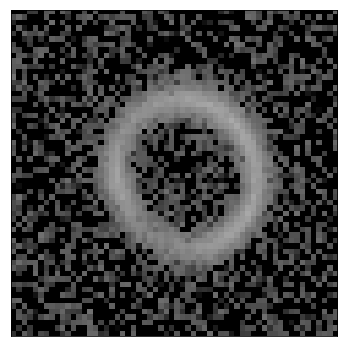

In [4]:
# display the initial simulated image

cmap_string = 'gray'
cmap = plt.get_cmap(cmap_string)
cmap.set_bad(color='k', alpha=1.)
cmap.set_under('k')

v_min = -4
v_max = 1

f, axes = plt.subplots(1, 1, figsize=(6, 6), sharex=False, sharey=False)

# sequence of weak lensing
ax = axes
im = ax.matshow(np.log10(image_real), origin='lower', vmin=v_min, vmax=v_max, cmap=cmap, extent=[0, 1, 0, 1])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.autoscale(False)

plt.show()

In [5]:
# lens models
fixed_lens = []
kwargs_lens_init = []
kwargs_lens_sigma = []
kwargs_lower_lens = []
kwargs_upper_lens = []

fixed_lens.append({})  # for this example, we fix the power-law index of the lens model to be isothermal
kwargs_lens_init.append(kwargs_spemd)
kwargs_lens_sigma.append({'theta_E': .1, 'e1': 0.05, 'e2': 0.05, 'gamma': 0.1
                    , 'center_x': 0.01, 'center_y': 0.01})
kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10})
kwargs_upper_lens.append({'theta_E': 10., 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10})

fixed_lens.append({'ra_0': 0, 'dec_0': 0})
kwargs_lens_init.append(kwargs_shear)
kwargs_lens_sigma.append({'gamma1': 0.01, 'gamma2': 0.01})
kwargs_lower_lens.append({'gamma1': -0.2, 'gamma2': -0.2})
kwargs_upper_lens.append({'gamma1': 0.2, 'gamma2': 0.2})

lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


fixed_source = []
kwargs_source_init = []
kwargs_source_sigma = []
kwargs_lower_source = []
kwargs_upper_source = []


fixed_source.append({})
kwargs_source_init.append(kwargs_sersic)
kwargs_source_sigma.append({'n_sersic': 0.1, 'R_sersic': 0.01, 'e1': 0.05, 'e2': 0.05, 'center_x': 0.05, 'center_y': 0.05})
kwargs_lower_source.append({'e1': -0.5, 'e2': -0.5, 'R_sersic': 0.001, 'n_sersic': .5, 'center_x': -10, 'center_y': -10})
kwargs_upper_source.append({'e1': 0.5, 'e2': 0.5, 'R_sersic': 10, 'n_sersic': 5., 'center_x': 10, 'center_y': 10})

source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]

kwargs_params = {'lens_model': lens_params,
                'source_model': source_params}


In [6]:
kwargs_likelihood = {'source_marg': False}
kwargs_model = {'lens_model_list': lens_model_list, 'source_light_model_list': source_model_list}

multi_band_list = [[kwargs_data, kwargs_psf, kwargs_numerics]]
kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
kwargs_constraints = {}

from lenstronomy.Workflow.fitting_sequence import FittingSequence
fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

fitting_kwargs_list = [['MCMC', {'n_burn': 200, 'n_run': 600, 'walkerRatio': 10, 'sigma_scale': 1.}]
        ]

chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
kwargs_result = fitting_seq.best_fit()

Computing the MCMC...
Number of walkers =  140
Burn-in iterations:  200
Sampling iterations: 600
217.30221605300903 time taken for MCMC sampling


## analyse MCMC chain

-1.0191087814457032 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.8840817359838957


/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:82: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',


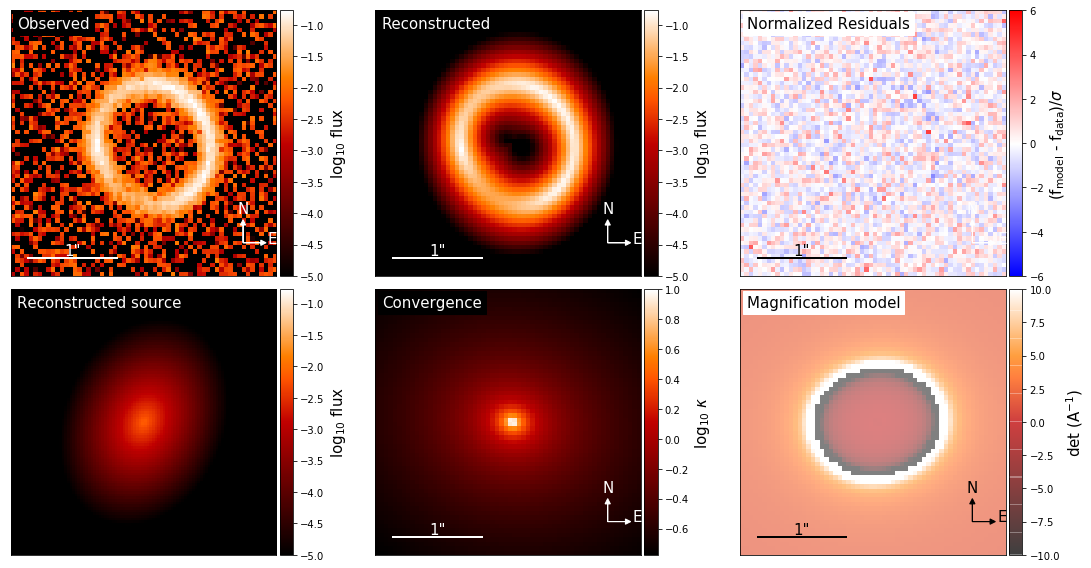

/Users/sibirrer/Software/lenstronomy/lenstronomy/Plots/model_band_plot.py:474: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


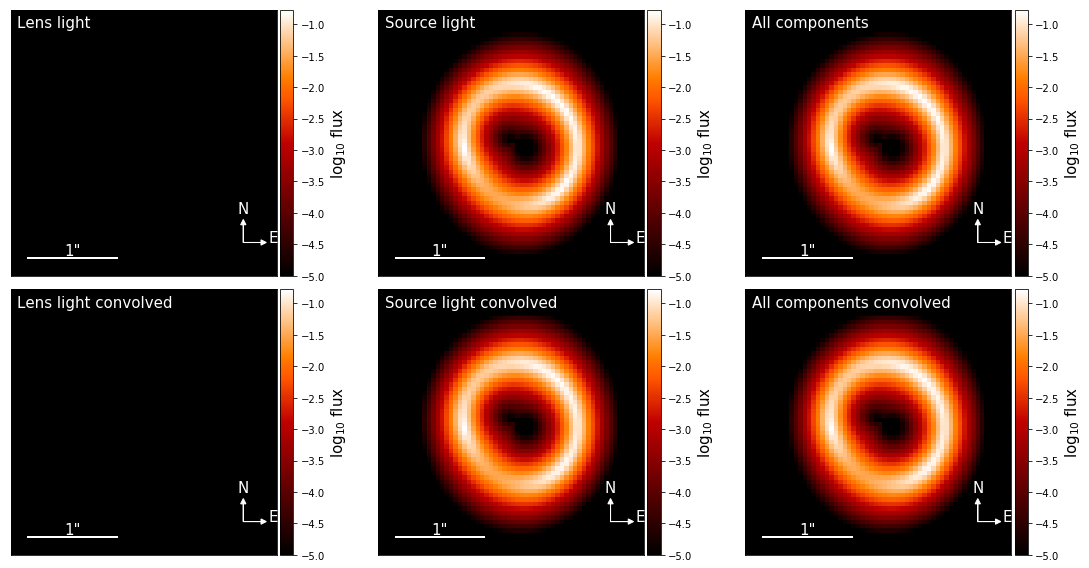

{'kwargs_lens': [{'theta_E': 0.66, 'gamma': 1.95, 'center_x': 0.05, 'center_y': 0, 'e1': 0.07, 'e2': -0.03}, {'gamma1': 0.0, 'gamma2': -0.05}], 'kwargs_source': [{'amp': 15.171199827348397, 'R_sersic': 0.1, 'n_sersic': 1, 'e1': -0.1, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0}], 'kwargs_lens_light': [], 'kwargs_ps': [], 'kwargs_special': {}, 'kwargs_extinction': []}


In [7]:
from lenstronomy.Plots import chain_plot
from lenstronomy.Plots.model_plot import ModelPlot

modelPlot = ModelPlot(multi_band_list, kwargs_model, kwargs_result, arrow_size=0.02, cmap_string="gist_heat")
    
f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.data_plot(ax=axes[0,0])
modelPlot.model_plot(ax=axes[0,1])
modelPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6)
modelPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=100)
modelPlot.convergence_plot(ax=axes[1, 1], v_max=1)
modelPlot.magnification_plot(ax=axes[1, 2])
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()

f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

modelPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True)
modelPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True)
modelPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True)
modelPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True)
f.tight_layout()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
plt.show()
print(kwargs_result)

number of non-linear parameters in the MCMC process:  14
parameters in order:  ['theta_E_lens0', 'gamma_lens0', 'e1_lens0', 'e2_lens0', 'center_x_lens0', 'center_y_lens0', 'gamma1_lens1', 'gamma2_lens1', 'R_sersic_source_light0', 'n_sersic_source_light0', 'e1_source_light0', 'e2_source_light0', 'center_x_source_light0', 'center_y_source_light0']
number of evaluations in the MCMC process:  84000
84000


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:16: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  app.launch_new_instance()


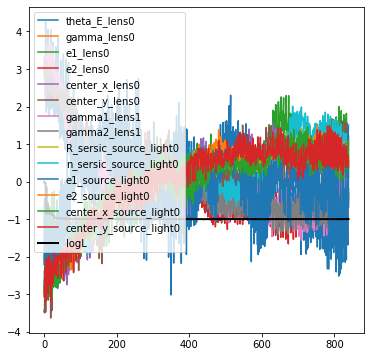

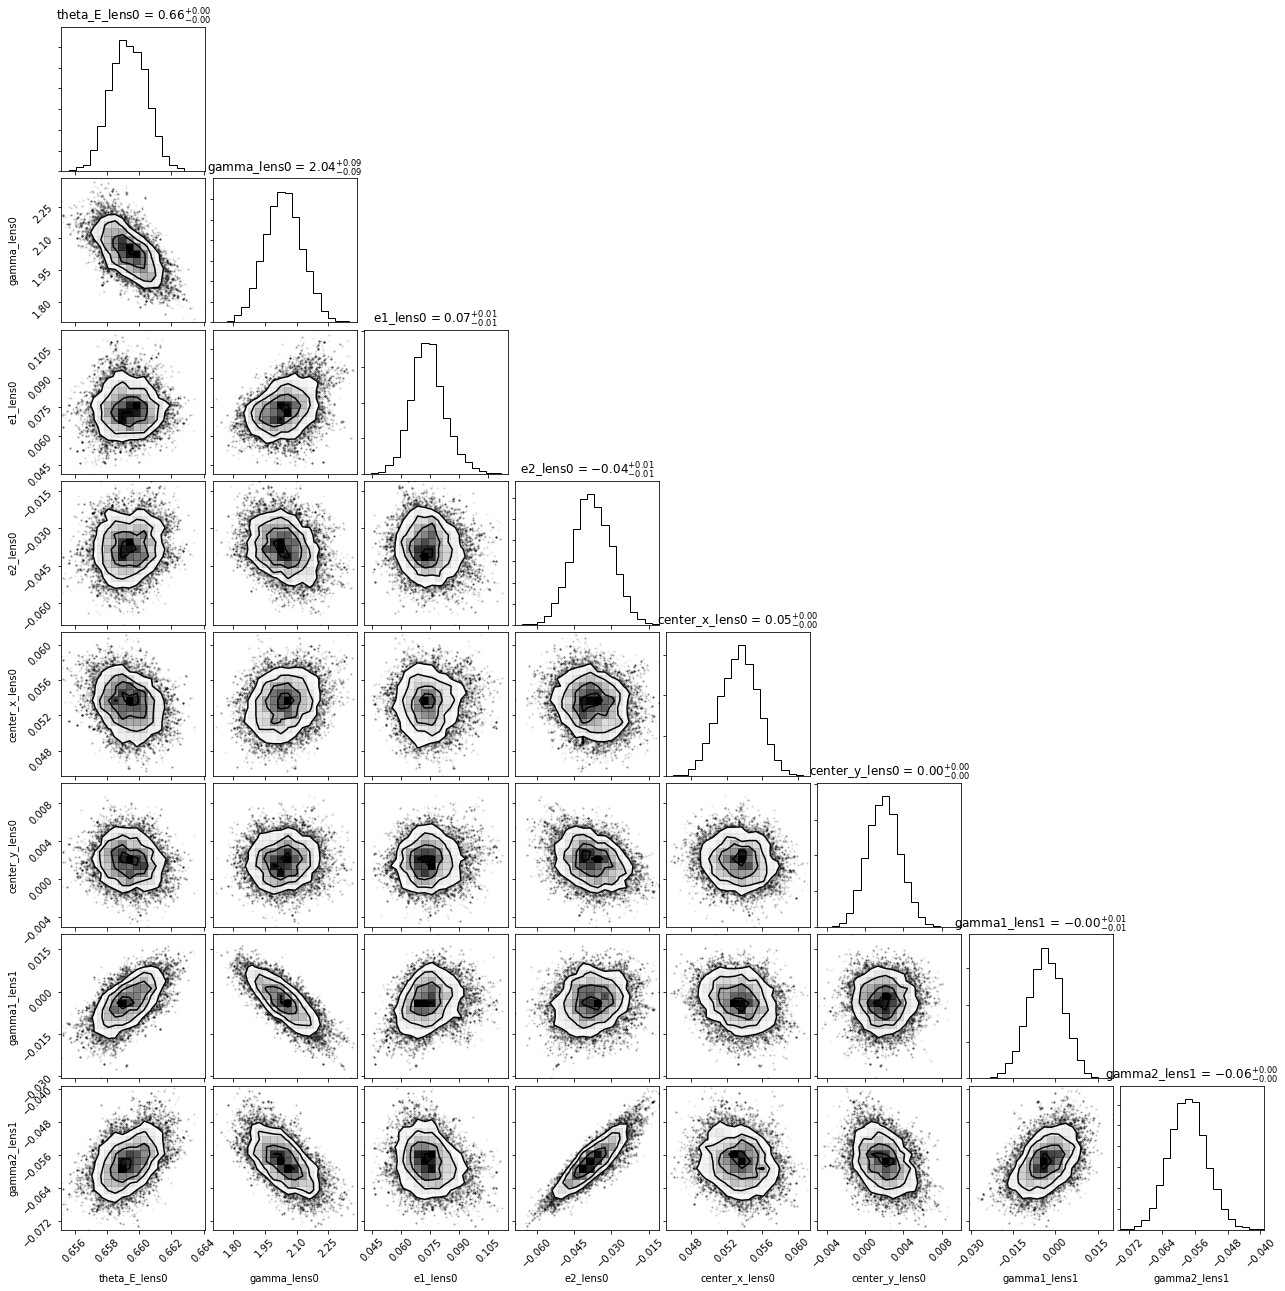

In [8]:
# the results of the MCMC chain, split in two corner plots

sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]

for i in range(len(chain_list)):
    chain_plot.plot_chain_list(chain_list, i)
    


print("number of non-linear parameters in the MCMC process: ", len(param_mcmc))
print("parameters in order: ", param_mcmc)
print("number of evaluations in the MCMC process: ", np.shape(samples_mcmc)[0])
n_sample = len(samples_mcmc)
print(n_sample)
samples_mcmc_cut = samples_mcmc[int(n_sample*1/2.):]
if not samples_mcmc == []:
    n, num_param = np.shape(samples_mcmc_cut)
    plot = corner.corner(samples_mcmc_cut[:,:8], labels=param_mcmc[:8], show_titles=True)
    #plot = corner.corner(samples_mcmc[:,8:], labels=param_mcmc[8:], show_titles=True)